# Node probing for AIFB dataset and GCN

Here we'll first be loading the dataset and explore its structure

In [1]:
#dataset MUTAG
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Entities
from torch_geometric.transforms import TargetIndegree

# Load the AIFB dataset
dataset = Entities(root='/tmp/AIFB', name='AIFB')
dataset[0]

Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285)

In [2]:
# import rdflib
# from collections import defaultdict

# # Load the AIFB dataset
# graph = rdflib.Graph()
# graph.parse("aifb_dataset.ttl", format="ttl")

# # Dictionary to store node labels
# node_labels = defaultdict(list)

# # Iterate through the triples and extract rdf:type triples
# for subj, pred, obj in graph:
#     if pred == rdflib.RDF.type:
#         node_labels[subj].append(obj)

# # Remove rdf:type triples from the graph
# graph.remove((None, rdflib.RDF.type, None))

# # Print the labels for each node
# for node, labels in node_labels.items():
#     print(f"Node: {node}, Labels: {labels}")


In [3]:
# from torch_geometric.datasets import TUDataset
# #utag
# mutag = TUDataset(root='/tmp/MUTAG', name='MUTAG')
# mutag
# mutag[0]

In [4]:
data = dataset[0]  # AIFB is a single graph

# Create one-hot encoded node features for the entire dataset
num_nodes = data.num_nodes
data.x = torch.eye(num_nodes)  # One-hot encoding for all nodes


In [5]:
dataset.data = data  # This line ensures the dataset now references the modified data

In [6]:
dataset.data

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(edge_index=[2, 58086], edge_type=[58086], train_idx=[140], train_y=[140], test_idx=[36], test_y=[36], num_nodes=8285, x=[8285, 8285])

In [7]:
#how much different relations in AIFB dataset
if 'edge_type' in data:
    edge_types = data.edge_type
    unique_edge_types = torch.unique(edge_types)
    num_relations = len(unique_edge_types)
    print(f'Number of different relations in AIFB dataset: {num_relations}')
else:
    print('Edge types not found in the dataset.')

Number of different relations in AIFB dataset: 90


Model

In [8]:
#set the seed
torch.manual_seed(37)

MODEL = "RGCN"
DATASET = "AIFB"

from models.models_AIFB import RGCN_framework as framework # import the model

gnn = framework(dataset)


Number of classes: 4


In [ ]:
# gnn.iterate()

In [9]:
# gnn.train()

In [13]:
#save the model 
# gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")

INFO:root:Model saved in: models/AIFB_RGCN.pt


In [14]:
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")

INFO:root:Model loaded from: models/AIFB_RGCN.pt


In [15]:
gnn.evaluate()

Final Evaluation - Train Acc: 0.971, Test Acc: 0.944


### Features / embeddings

```plaintext
[
    (
        Feature shape: torch.Size([8285, 128]), x1,
        Feature shape: torch.Size([8285, 128]), x2,
        Feature shape: torch.Size([8285, 128]), x3,
        Feature shape: torch.Size([8285, 128]), x4,
        Feature shape: torch.Size([8285, 4]), x5
    ),
]

In [16]:
train_features, test_features = gnn.evaluate_with_features2()

Features generated from model, shape of output: [torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 128]), torch.Size([8285, 4])]
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 128]), train_indices max: 8240
Feature shape: torch.Size([8285, 4]), train_indices max: 8240


In [17]:
print(len(train_features[0]))
print(len(test_features[0]))
len(train_features), len(test_features)

140
36


(5, 5)

In [18]:
train_features[0][0].shape

(128,)

In [19]:
#print the possibles classes that we're classifying in train_y of dataset 
print(set(dataset.data.train_y.numpy()))

{0, 1, 2, 3}


c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### node properties

In [21]:
#we have the train_idx=[140], test_idx=[36]

#we want to calculate the node properties of the train and test nodes such as node degree, clustering coefficient, betweenness centrality, closeness centrality, eigenvector centrality, and pagerank. And get the train_node_properties and test_node_properties

#we will use the networkx library to calculate the node properties
# Convert PyTorch Geometric Data to NetworkX format
import networkx as nx
from torch_geometric.utils import to_networkx
import torch

G = to_networkx(data, to_undirected=True)

# Calculate various node properties using NetworkX
degree = dict(G.degree())
clustering = nx.clustering(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
pagerank = nx.pagerank(G)


In [22]:

# Create a function to gather properties for specific nodes
def get_node_properties(indices):
    properties = []
    for idx in indices:
        properties.append({
            'degree': degree[idx],
            'clustering': clustering[idx],
            'betweenness': betweenness[idx],
            'closeness': closeness[idx],
            'eigenvector': eigenvector[idx],
            'pagerank': pagerank[idx]
        })
    return properties

# Extract node properties for train and test indices
train_node_properties = get_node_properties(data.train_idx.tolist())
test_node_properties = get_node_properties(data.test_idx.tolist())

# Convert to tensor format if needed
train_node_properties_tensor = {key: torch.tensor([prop[key] for prop in train_node_properties]) for key in train_node_properties[0]}
test_node_properties_tensor = {key: torch.tensor([prop[key] for prop in test_node_properties]) for key in test_node_properties[0]}



## Diagnostic classifier 

#### One classifier per node to select the nodes that seem to be encoded in the representations

Training on Single Data points :
The way train_probe_for_node is structured, it seems to be training on a single data point at a time (each node's features), which was fine because intended, but it's crucial to understand that this will lead to very limited learning. In such a case, R² might not be meaningful as it’s computed over a single sample.

Training on multiple data points : 
The goal now is to train on multiple data points with one linear classifier : 
Features are typically of the shape :


```plaintext
[
    (
        Feature shape: torch.Size([8285, 128]), x1,
        Feature shape: torch.Size([8285, 128]), x2,
        Feature shape: torch.Size([8285, 128]), x3,
        Feature shape: torch.Size([8285, 128]), x4,
        Feature shape: torch.Size([8285, 4]), x5
    ),
]


as they are a list of layer embeddings. Each layer has a list of node embeddings (140 node in the train_features for exemple) and each node has a vector of 128 features that represent it. We want to plot the R2 scores of the different properties in the different layers. To change this point we need to pass from the paradigm where we probe each node with a different probe to a paradigm where we have one probe for each property and each layer, and we train it on the train set and test it on the test set. 

code a bit more modular to plot afterwards

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_node(features, property_value, num_epochs=1000, learning_rate=0.01):
    # Convert features to PyTorch tensor if it's a NumPy array
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)

    # Ensure it's 2D: (1, feature_size)
    if len(features.shape) == 1:
        features = features.unsqueeze(0)
    
    print(f"Training on features with shape: {features.shape} for property value: {property_value}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (1, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Convert property_value to PyTorch tensor
    property_value = torch.tensor([property_value], dtype=torch.float32).unsqueeze(0)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features)
        loss = criterion(output, property_value)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(features)
        mse = criterion(pred, property_value).item()
        r2 = r2_score(property_value.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_node_probes(train_features, test_features, train_properties, test_properties):
    num_layers = len(train_features)
    results = []

    for layer_idx in range(num_layers):
        layer_train_features = train_features[layer_idx]
        layer_test_features = test_features[layer_idx]
        
        # Iterate over each node for training
        mse_scores, r2_scores = [], []
        for node_idx, node_features in enumerate(layer_train_features):
            node_property = train_properties[node_idx]
            mse, r2 = train_probe_for_node(node_features, node_property['degree'])  # Example for 'degree'
            mse_scores.append(mse)
            r2_scores.append(r2)
        
        results.append({
            'layer': layer_idx,
            'mse_scores': mse_scores,
            'r2_scores': r2_scores
        })
    
    return results

def plot_results(results):
    for result in results:
        layer = result['layer']
        plt.figure(figsize=(10, 4))
        
        # Plot MSE Distribution
        plt.subplot(1, 2, 1)
        plt.hist(result['mse_scores'], bins=30)
        plt.title(f'Layer {layer} - MSE Distribution')
        plt.xlabel('MSE Score')
        plt.ylabel('Frequency')

        # Clean up r2_scores by removing NaNs
        clean_r2_scores = [r2 for r2 in result['r2_scores'] if not np.isnan(r2)]

        # Plot R² Score Distribution
        plt.subplot(1, 2, 2)
        if clean_r2_scores:  # Only plot if we have valid R² scores
            plt.hist(clean_r2_scores, bins=30)
            plt.title(f'Layer {layer} - R² Score Distribution')
            plt.xlabel('R² Score')
            plt.ylabel('Frequency')
        else:
            plt.title(f'Layer {layer} - No valid R² scores')
            plt.xlabel('R² Score')
            plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()

# Assuming train_features, test_features, train_properties, test_properties are already defined
results = evaluate_node_probes(train_features, test_features, train_node_properties, test_node_properties)

Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 128]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 32


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 125


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 67


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 38


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 26


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 21


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 35


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 25


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 83


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 252


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 34


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 7


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 11


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 95


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 64


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 8


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 52


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 19


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 60


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 79


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 22


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 85


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 51


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 15


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 41


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 33


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 66


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 43


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 30


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 202


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 16


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 23


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 3


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 14


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 27


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 18


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 5


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 10


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 17


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 9


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 12


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 36


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 6


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 4


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 29


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 78


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 13


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 31


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Training on features with shape: torch.Size([1, 4]) for property value: 20


c:\Users\tomdu\miniconda3\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


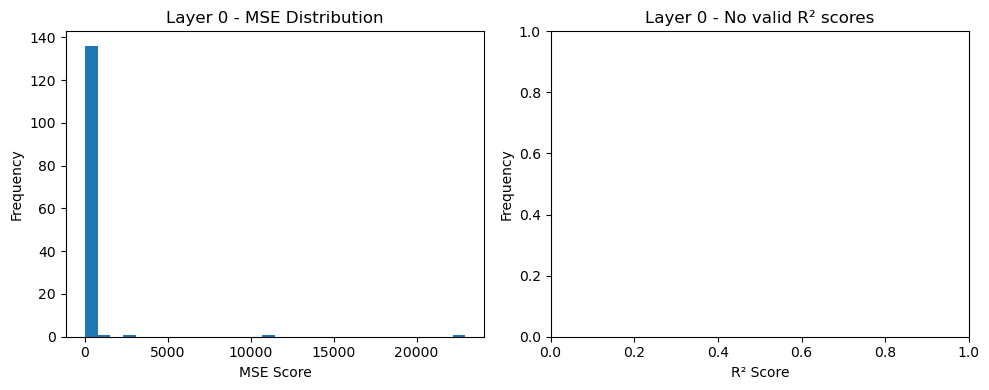

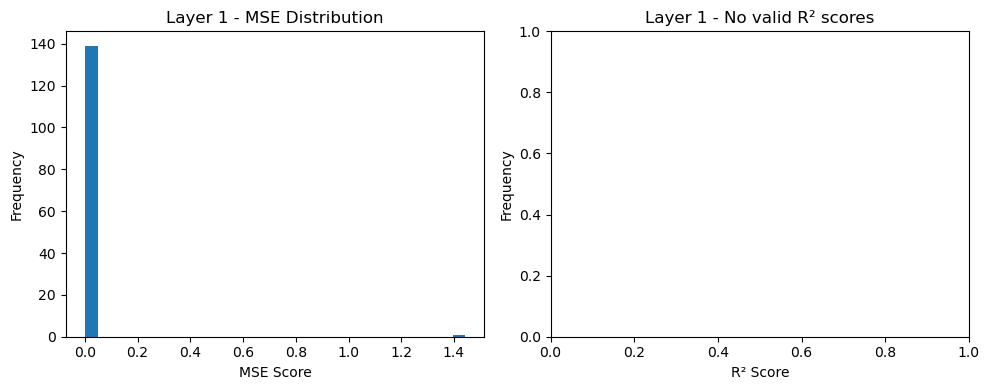

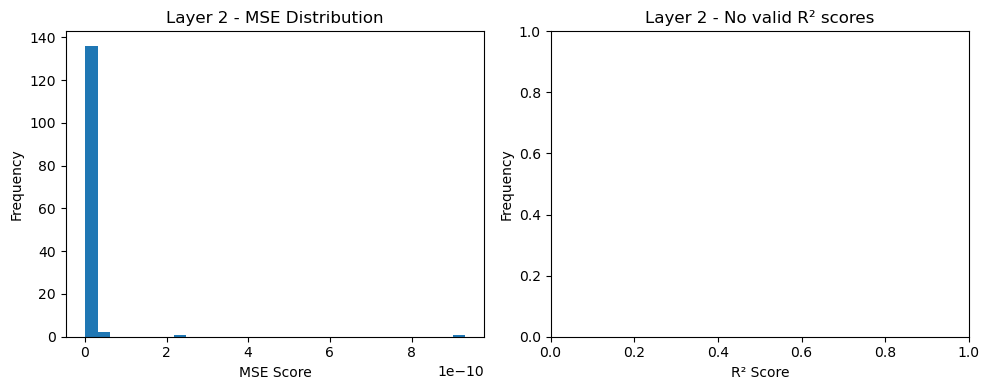

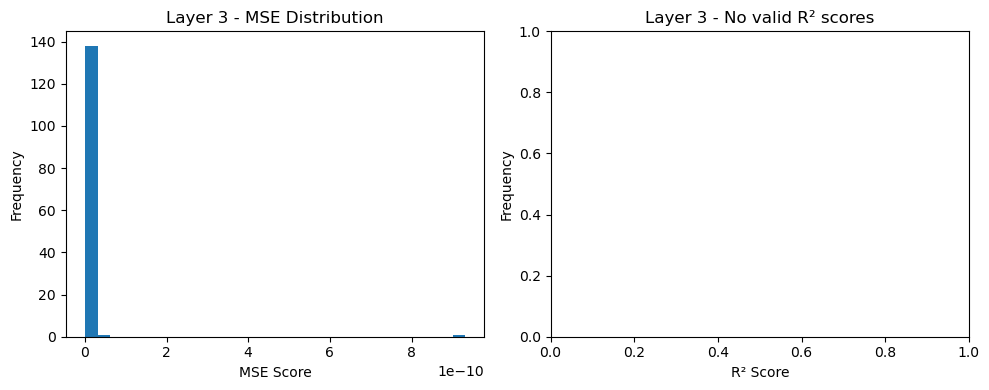

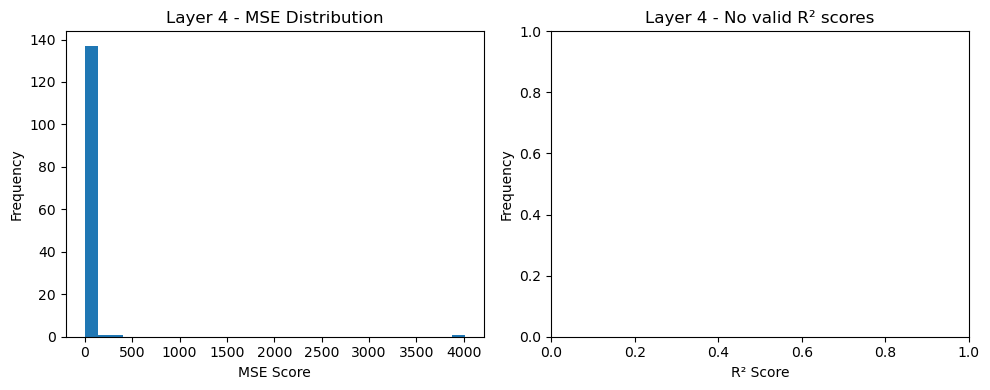

In [31]:
# In another cell
plot_results(results)

Conclusion : it seems we can learn for all the nodes their node degree, except one or two nodes which might not have their node degree encoded in their representation because they are not usefull for the classification. Maybe disconnected nodes or something similar. Let's explore this 

In [32]:
#find the node indexes where the MSE score is bigger than 1
def find_bad_nodes(results):
    bad_nodes = []
    for result in results:
        for idx, mse in enumerate(result['mse_scores']):
            if mse > 1:
                bad_nodes.append((result['layer'], idx))
    return bad_nodes

bad_nodes = find_bad_nodes(results)
print(bad_nodes)

#link these indexes to the real node indexes data.train_idx.tolist()
bad_nodes_real = [(data.train_idx.tolist()[node_idx], layer) for layer, node_idx in bad_nodes]
print(bad_nodes_real)

[(0, 12), (0, 31), (0, 50), (0, 53), (0, 56), (0, 60), (0, 66), (0, 76), (0, 82), (0, 83), (0, 88), (0, 97), (0, 99), (0, 101), (0, 108), (0, 109), (0, 112), (0, 136), (0, 138), (1, 66), (4, 12), (4, 31), (4, 50), (4, 60), (4, 66), (4, 99), (4, 112)]
[(5117, 0), (49, 0), (6627, 0), (3994, 0), (4451, 0), (7950, 0), (4027, 0), (3378, 0), (251, 0), (4317, 0), (4538, 0), (1102, 0), (2028, 0), (4868, 0), (8020, 0), (5279, 0), (3721, 0), (6187, 0), (4634, 0), (4027, 1), (5117, 4), (49, 4), (6627, 4), (7950, 4), (4027, 4), (2028, 4), (3721, 4)]


In [33]:
#check the node properties of the bad nodes
bad_node_properties = get_node_properties([node_idx for node_idx, _ in bad_nodes_real])
print(bad_node_properties)

[{'degree': 125, 'clustering': 0, 'betweenness': 0.008154526537527148, 'closeness': 0.3063603242260895, 'eigenvector': 0.03888084838137091, 'pagerank': 0.002251184259099826}, {'degree': 67, 'clustering': 0.04703753957485301, 'betweenness': 0.004920361685615264, 'closeness': 0.3114304164764179, 'eigenvector': 0.013365620246218273, 'pagerank': 0.0012147344866637933}, {'degree': 51, 'clustering': 0.043137254901960784, 'betweenness': 0.0034553297750856476, 'closeness': 0.30079560006025075, 'eigenvector': 0.00902353962572659, 'pagerank': 0.0009509549438060417}, {'degree': 78, 'clustering': 0.014985014985014986, 'betweenness': 0.004897444745800325, 'closeness': 0.32446414369130927, 'eigenvector': 0.030352655650128017, 'pagerank': 0.0013917749203416897}, {'degree': 83, 'clustering': 0.05495151337055539, 'betweenness': 0.0047984822513608815, 'closeness': 0.3457202706830281, 'eigenvector': 0.036037199679192417, 'pagerank': 0.0013848883804956063}, {'degree': 78, 'clustering': 0.04162504162504162

In [34]:
#find the good nodes by filtering the bad nodes thanks to their index
good_nodes = [node for node in data.train_idx.tolist() if node not in [node_idx for node_idx, _ in bad_nodes_real]]
print(good_nodes)

#check the node properties of the good nodes
good_node_properties = get_node_properties(good_nodes)
print(good_node_properties)

#max degree of the good nodes
max_degree = max([prop['degree'] for prop in good_node_properties])
print(max_degree)

[2862, 2570, 153, 2146, 7403, 2555, 3013, 684, 6472, 7745, 6704, 3944, 6953, 3926, 6084, 948, 269, 6766, 1145, 4726, 4543, 3537, 90, 186, 2941, 2179, 170, 2894, 1593, 6820, 7477, 8055, 8219, 8030, 1345, 4402, 4651, 8229, 279, 104, 7844, 6275, 4845, 3970, 4572, 1862, 1298, 5268, 795, 6378, 854, 3135, 1535, 329, 3759, 5709, 1509, 2764, 2893, 3216, 3168, 6925, 4769, 5307, 7554, 1558, 2136, 1746, 6431, 6121, 194, 1973, 979, 388, 5214, 3699, 1556, 2237, 8144, 3524, 7858, 378, 2879, 3790, 3967, 1440, 3536, 5172, 1056, 5727, 8010, 11, 4847, 1893, 3827, 8133, 5208, 3960, 5873, 5356, 4870, 3903, 8135, 1374, 4474, 3279, 5990, 5942, 1962, 7804, 3081, 1919, 3082, 2, 451, 692, 8035, 3366, 3547, 8240, 491]
[{'degree': 3, 'clustering': 0, 'betweenness': 0.00026100875107330383, 'closeness': 0.2944942553300086, 'eigenvector': 0.0010154048293499042, 'pagerank': 9.80311622657992e-05}, {'degree': 17, 'clustering': 0, 'betweenness': 0.0008793453142243213, 'closeness': 0.29890619410340863, 'eigenvector': 0.

Conclusion bis : seems like 78 is the limit from which we can't predict the node degree anymore. Weird.

## Probe for different properties with a one classifier per property across all nodes

The code aggregates all node embeddings within a layer into a single feature matrix. It then trains a single linear model (probe) to predict the corresponding property values (e.g., "degree") across all nodes in that layer. This means the probe is treating the layer as a whole and learning to map the entire layer's embedding space to the property values collectively. This approach is more about understanding how the entire layer's representation relates to the properties collectively.

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

def train_probe_for_layer(features, property_values, test_features, test_property_values, num_epochs=10000, learning_rate=0.01):
    # Convert features and property values to PyTorch tensors if they are NumPy arrays
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)
    if isinstance(property_values, np.ndarray):
        property_values = torch.tensor(property_values, dtype=torch.float32)

    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(test_property_values, np.ndarray):
        test_property_values = torch.tensor(test_property_values, dtype=torch.float32)

    print(f"Training on features with shape: {features.shape} for property values shape: {property_values.shape}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (num_nodes, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features).squeeze()  # Remove single-dimensional entries
        loss = criterion(output, property_values)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        pred = model(test_features).squeeze()
        mse = criterion(pred, test_property_values).item()
        # Flatten the tensors for proper use of r2_score
        r2 = r2_score(test_property_values.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

def evaluate_layer_probes(train_features, test_features, train_properties, test_properties):
    num_layers = len(train_features)
    results = []

    for layer_idx in range(num_layers):
        layer_train_features = train_features[layer_idx]
        layer_test_features = test_features[layer_idx]

        # Stack node features into a single matrix for each layer
        train_feature_matrix = np.vstack(layer_train_features)  # Shape: (num_nodes, feature_size)
        test_feature_matrix = np.vstack(layer_test_features)

        # Train and evaluate probe for each property
        for property_name in train_properties[0].keys():  # Assuming all nodes have the same properties
            train_property_values = np.array([node[property_name] for node in train_properties])
            test_property_values = np.array([node[property_name] for node in test_properties])

            mse, r2 = train_probe_for_layer(train_feature_matrix, train_property_values, test_feature_matrix, test_property_values)
            
            results.append({
                'layer': layer_idx,
                'property': property_name,
                'mse': mse,
                'r2': r2
            })

    return results

def plot_results(results):
    layers = sorted(set(result['layer'] for result in results))
    properties = sorted(set(result['property'] for result in results))
    
    plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
    
    for property_name in properties:
        r2_scores = []
        for layer in layers:
            layer_results = [r for r in results if r['layer'] == layer and r['property'] == property_name]
            # Calculate mean R² score for the layer
            mean_r2 = np.mean([r['r2'] for r in layer_results])
            # Set any R² value below -0.05 to -0.05
            if mean_r2 < -0.05:
                mean_r2 = -0.05
            r2_scores.append(mean_r2)
        
        # Plot the R² scores with crosses and lines
        plt.plot(layers, r2_scores, marker='x', linestyle='-', label=property_name)

    # Set the x-ticks to be the layer names
    plt.xticks(ticks=layers, labels=[f'Layer {layer}' for layer in layers])

    plt.title('R² Scores Across Layers for Different Properties')
    plt.xlabel('Layer')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)  # Add grid for better visibility of points and lines
    plt.show()

# Assuming train_features, test_features, train_properties, test_properties are already defined
results = evaluate_layer_probes(train_features, test_features, train_node_properties, test_node_properties)




Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Size([140])
Training on features with shape: torch.Size([140, 128]) for property values shape: torch.Si

In [45]:
#save the results
import pickle

with open('results/'+DATASET+'_'+MODEL+'_node_probing.pkl', 'wb') as f:
    pickle.dump(results, f)

#load the results
import pickle

with open('results/'+DATASET+'_'+MODEL+'_node_probing.pkl', 'rb') as f:
    results = pickle.load(f)


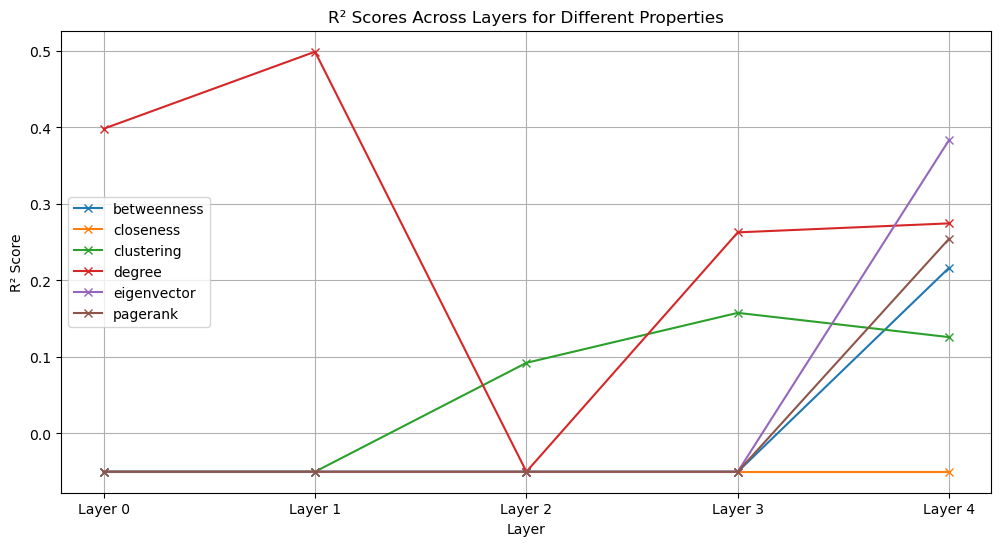

In [37]:
plot_results(results)

In [43]:
# Identify unique layers
layers = set(result['layer'] for result in results)

for layer in layers:
    # Filter results for the current layer
    layer_results = [result for result in results if result['layer'] == layer]
    
    # Extract and sort r2 values along with property names in descending order
    sorted_r2_values = sorted([(result['r2'], result['property']) for result in layer_results], reverse=True, key=lambda x: x[0])
    
    # Print the sorted r2 values with property names for the current layer
    print(f"Layer {layer}:")
    for r2, property in sorted_r2_values:
        print(f"  Property: {property}, R2: {r2}")
    print()  # Add a blank line for better readability

Layer 0:
  Property: degree, R2: 0.39824431141896455
  Property: closeness, R2: -0.5751628503060366
  Property: betweenness, R2: -0.9555418256409218
  Property: eigenvector, R2: -1.0127013975724473
  Property: clustering, R2: -2.4487026738273703
  Property: pagerank, R2: -106.16420902599496

Layer 1:
  Property: degree, R2: 0.49890138898464365
  Property: closeness, R2: -0.10932475992487367
  Property: eigenvector, R2: -0.3351135137677197
  Property: clustering, R2: -0.34516717413776377
  Property: betweenness, R2: -8.05958541656977
  Property: pagerank, R2: -32.65167010216267

Layer 2:
  Property: clustering, R2: 0.0923155710967184
  Property: degree, R2: -0.25393757403796036
  Property: eigenvector, R2: -3.9661360184450976
  Property: closeness, R2: -5.3929518349161665
  Property: betweenness, R2: -156.15474061649093
  Property: pagerank, R2: -2608.0311531053003

Layer 3:
  Property: degree, R2: 0.26281751304042944
  Property: clustering, R2: 0.15763208088668734
  Property: closeness